In [1]:
import numpy as np
import os
import itertools
import time
import multiprocessing as mp
from pathlib import Path

import torch
from torch.utils.data import DataLoader

from qtorch.quant import Quantizer, quantizer
from qtorch.optim import OptimLP
from torch.optim import SGD
from qtorch import FloatingPoint
from qtorch.auto_low import sequential_lower
import math
from scipy.stats import sem # standard error
import tensorly as tl
import itertools

import sys
sys.path.append('..')
import train_func as tf
# import utils

import mkl
mkl.set_num_threads(1)

import apgpy
from sklearn.utils.extmath import randomized_svd

In [2]:
def relative_error(mtx_true, mtx_pred):
    return np.linalg.norm(mtx_true - mtx_pred) / np.linalg.norm(mtx_true)

In [3]:
data_path = os.path.join(Path(os.getcwd()).parent.absolute(), 'data')

accuracy_matrix = np.load(os.path.join(data_path, 'acc_matrix_res64_all.npy'))
memory_matrix = np.load(os.path.join(data_path, 'mem_matrix_full.npy'))
error_matrix = 1 - accuracy_matrix

idx_dataset_to_remove = 28 # remove full CIFAR100
memory_matrix = np.delete(memory_matrix, idx_dataset_to_remove, axis=0)
error_matrix = np.delete(error_matrix, idx_dataset_to_remove, axis=0)

In [4]:
from scipy.stats import sem
from matplotlib import pyplot as plt
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
from matplotlib import rc
rc('font', **{'family': 'serif', 'serif': ['Computer Modern'], 'weight': 'bold'})
rc('text', usetex=True)

from scipy.sparse.linalg import svds

singular value plots

In [5]:
s = np.linalg.svd(error_matrix, compute_uv=False)

In [6]:
np.sum(s[:5]) / np.sum(s)

0.7795066891444642

(array([-10.,   0.,  10.,  20.,  30.,  40.]),
 <a list of 6 Text xticklabel objects>)

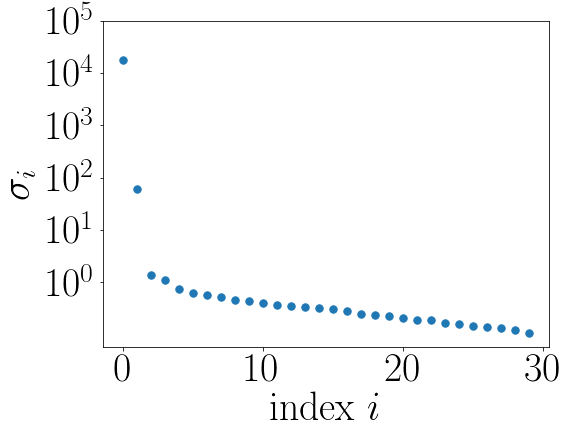

In [7]:
fontsize_axes = 40
scatter_size = 55

rc('font', **{'family': 'serif', 'serif': ['Computer Modern'], 'size': 22, 'weight': 'bold'})
rc('text', usetex=True)
fig, ax = plt.subplots(figsize=(8,6))

ax.scatter(np.arange(30), np.log(s[:30]), s=scatter_size)
ax.set_xlabel(r'index $i$', fontsize=fontsize_axes)
ax.set_ylabel(r'$\sigma_i$', fontsize=fontsize_axes)
ax.set_yticks(np.arange(6))
ax.set_yticklabels([r'$10^{}$'.format(n) for n in np.arange(6)], fontsize=fontsize_axes)
plt.xticks(fontsize=fontsize_axes)

In [8]:
def approx_matrix_rank(a, threshold=0.03):
    """Compute approximate rank of a matrix.
    Args:
        a (np.ndarray):    Matrix for which to compute rank.
        threshold (float): All singular values less than threshold * (largest singular value) will be set to 0
    Returns:
        int: The approximate rank of a.
    """
    s = np.linalg.svd(a, compute_uv=False)
    rank = s[s >= threshold * s[0]]
    return len(rank)

In [9]:
def pca(a, rank=None, threshold=None):
    """Solves: minimize ||A_XY||^2 where ||.|| is the Frobenius norm.
    Args:
        a (np.ndarray):    Matrix for which to compute PCA.
        threshold (float): Threshold specifying approximate rank of a.
        rank (int):        The approximate rank.
    Returns:
        x, y (np.ndarray): The solutions to the PCA problem.
        vt (np.ndarray):   Transpose of V as specified in the singular value decomposition.
    """
    assert (threshold is None) != (rank is None), "Exactly one of threshold and rank should be specified."
    if threshold is not None:
        rank = approx_matrix_rank(a, threshold)
    u, s, vt = svds(a, k=rank)

    nonzero_pos = np.where(s > 0)[0]
    s = s[nonzero_pos]
    u = u[:, nonzero_pos]
    vt = vt[nonzero_pos, :]

    u = np.fliplr(u)
    s = np.flipud(s)
    vt = np.flipud(vt)

    sigma = np.diag(s)
    x = np.dot(u, sigma).T
    y = vt
    return x, y, vt

In [10]:
# low precision configurations
low_formats = [['Representation_Float', '5', 1],['Representation_Float', '6', 2],
               ['Representation_Float', '7', 3],['Representation_Float', '8', 4],
               ['Representation_Float', '6', 1],['Representation_Float', '7', 2],
               ['Representation_Float', '8', 3],['Representation_Float', '9', 4],
               ['Representation_Float', '7', 1],['Representation_Float', '8', 2],
               ['Representation_Float', '9', 3]]

high_formats = [['Representation_Float', '14', 7],['Representation_Float', '16', 9],
                ['Representation_Float', '18', 11],['Representation_Float', '15', 7],
                ['Representation_Float', '17', 9],['Representation_Float', '19', 11],
                ['Representation_Float', '16', 7],['Representation_Float', '18', 9],
                ['Representation_Float', '20', 11]]

lp_configs = list(itertools.product(low_formats, high_formats))

# settings_all = np.full(error_matrix.shape, np.nan)
settings_all = []

for i in range(error_matrix.shape[0]):
    for j in range(error_matrix.shape[1]):
        settings_all.append((i, lp_configs[j]))

settings_all = np.array(settings_all)

In [11]:
memory_matrix_flattened = memory_matrix.flatten()
error_matrix_flattened = error_matrix.flatten()

In [12]:
def is_pareto_efficient_dumb(costs):
    """
    Find the pareto-efficient points
    :param costs: An (n_points, n_costs) array
    :return: A (n_points, ) boolean array, indicating whether each point is Pareto efficient
    """
    is_efficient = np.ones(costs.shape[0], dtype = bool)
    for i, c in enumerate(costs):
        is_efficient[i] = np.all(np.any(costs[:i]>c, axis=1)) and np.all(np.any(costs[i+1:]>c, axis=1))
    return is_efficient

In [13]:
def weighted_softimpute(X, M, W, lmbda, max_rank=None,
                        min_value=None, max_value=None,
                        apg_max_iter=2500, apg_eps=1e-6,
                        apg_use_restart=True):
    m = X.shape[0]
    n = X.shape[1]

    def prox(Z, t):
        Z = Z.reshape(m, n)

        # singular value shrinkage
        if max_rank is None:
            U, S, VT = svds(Z, k=min(Z.shape)-1)
            U = np.fliplr(U)
            S = np.flipud(S)
            VT = np.flipud(VT)

        else:
            U, S, VT = randomized_svd(Z, max_rank)
        S = np.maximum(S - lmbda*t, 0)
        Z = np.dot(U * S, VT)

        # clip values
        if min_value is not None:
            mask = Z < min_value
            if mask.sum() > 0:
                Z[mask] = min_value
        if max_value is not None:
            mask = Z > max_value
            if mask.sum() > 0:
                Z[mask] = max_value

        return Z.flatten()

    M_one_mask = (M == 1)
    masked_weights = W[M_one_mask]
    masked_X = X[M_one_mask]
    def grad(Z):
        grad = np.zeros((m, n))
        grad[M_one_mask] = (Z.reshape(m, n)[M_one_mask] - masked_X) * masked_weights
        return grad.flatten()

    X_hat = apgpy.solve(grad, prox, np.zeros(m*n),
                        max_iters=apg_max_iter,
                        eps=apg_eps,
                        use_gra=True,
                        use_restart=apg_use_restart,
                        quiet=True).reshape((m, n))
    return X_hat

In [14]:
# Metric 1: convergence

def get_closest_dist(true_all, pred):
    """
    true_all: a (n_points, dim_points) array. 
    pred: the single point to compute distance from.
    """
    dist_all = []
    for ref in true_all:
        dist_all.append(np.linalg.norm(pred - ref))
    return np.min(dist_all)    

def get_convergence_metric(error_true_at_true_frontier, memory_true_at_true_frontier, 
                          error_pred_at_pred_frontier, memory_true_at_pred_frontier,
                          range_error_true, range_error_pred, range_memory):
    error_true_at_true_frontier_rescaled = error_true_at_true_frontier / range_error_true
    error_pred_at_pred_frontier_rescaled = error_pred_at_pred_frontier / range_error_pred
    memory_true_at_true_frontier_rescaled = memory_true_at_true_frontier / range_memory
    memory_true_at_pred_frontier_rescaled = memory_true_at_pred_frontier / range_memory
    
    costs_at_true_frontier = np.hstack((error_true_at_true_frontier_rescaled.reshape(-1, 1), 
                                        memory_true_at_true_frontier_rescaled.reshape(-1, 1)))
    costs_at_pred_frontier = np.hstack((error_pred_at_pred_frontier_rescaled.reshape(-1, 1), 
                                        memory_true_at_pred_frontier_rescaled.reshape(-1, 1)))
    
    dists = []
    for cost_pred in costs_at_pred_frontier:
        dists.append(get_closest_dist(costs_at_true_frontier, cost_pred))
    return np.average(dists)


# Metric 2: hypervolume difference
def hypervolume(x_all, y_all, x_max, y_max):
    x_all = np.array(x_all)
    y_all = np.array(y_all)
    
    assert all(x_all <= x_max), "there are x values larger than x_max"
    assert all(y_all <= y_max), "there are y values larger than y_max"
    assert len(x_all) == len(y_all)
    assert all((np.diff(x_all) >= 0) != (np.diff(y_all) >= 0)) # XOR
    x_all_sorted = np.sort(x_all)
    y_all_rev_sorted = -np.sort(-y_all)
    y_all_rev_sorted_diff = -np.diff(y_all_rev_sorted)
    y_all_rev_sorted_diff = np.insert(y_all_rev_sorted_diff, 0, y_max-y_all_rev_sorted[0])
    return np.sum([(x_max - x_all[i]) * y_all_rev_sorted_diff[i] for i in range(len(x_all))])
    

def hypervolume_difference(error_true_at_true_frontier, memory_true_at_true_frontier, 
                error_pred_at_pred_frontier, memory_true_at_pred_frontier,
                range_error_true, range_error_pred, range_memory, 
                max_error, max_memory):
    error_true_at_true_frontier_rescaled = error_true_at_true_frontier / range_error_true
    error_pred_at_pred_frontier_rescaled = error_pred_at_pred_frontier / range_error_pred
    memory_true_at_true_frontier_rescaled = memory_true_at_true_frontier / range_memory
    memory_true_at_pred_frontier_rescaled = memory_true_at_pred_frontier / range_memory
    max_error_rescaled = max_error / range_error_true
    max_memory_rescaled = max_memory / range_memory
    
    hypervolume_true = hypervolume(memory_true_at_true_frontier_rescaled, error_true_at_true_frontier_rescaled,
                                   max_memory_rescaled, max_error_rescaled)    
    hypervolume_pred = hypervolume(memory_true_at_pred_frontier_rescaled, error_pred_at_pred_frontier_rescaled,
                                   max_memory_rescaled, max_error_rescaled)
    
    return np.abs(hypervolume_pred - hypervolume_true) 
    

In [15]:
def uniform_sampling(ratio, matrix, initial_mask=None, seed=0):
    sampled_matrix = matrix.copy()
    np.random.seed(seed)
    if initial_mask is None:
        mask = np.random.choice([True, False], matrix.shape, p=[ratio, 1-ratio])
    else:
        assert initial_mask.shape == matrix.shape
        mask = initial_mask * np.random.choice([True, False], matrix.shape, p=[ratio, 1-ratio])
    sampled_matrix[np.invert(mask)] = np.nan
    return sampled_matrix, mask.astype(int)

In [16]:
def NormalizeData(data, min_value=0, max_value=1):
    pos = (data - np.min(data)) / (np.max(data) - np.min(data))    
    return min_value + pos * (max_value - min_value)

def NormalizeData_sqrt(data, min_value=0, max_value=1):
    pos = (data - np.min(data)) / (np.max(data) - np.min(data))    
    pos_sqrt = np.sqrt(pos)
    return min_value + pos_sqrt * (max_value - min_value)

def max_softmax(data, max_value, alpha=1):
    return np.exp(alpha * data) / np.exp(alpha * max_value)

def nonuniform_sampling(sampling_prob, matrix, initial_mask=None, seed=0):
    sampled_matrix = matrix.copy()
    np.random.seed(seed)
    if initial_mask is None:
        mask = (np.random.uniform(0, 1, sampling_prob.shape) < sampling_prob)
    else:
        assert initial_mask.shape == matrix.shape
        mask = initial_mask * (np.random.uniform(0, 1, sampling_prob.shape) < sampling_prob)
    sampled_matrix[np.invert(mask)] = np.nan
    return sampled_matrix, mask.astype(int)

# uniform sampling

In [17]:
observation_ratios = np.linspace(0.05, 0.5, 10).round(decimals=2)

In [18]:
observation_ratios

array([0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ])

In [19]:
memory_matrix_part = memory_matrix
error_matrix_part = error_matrix

memory_matrix_part_flattened = memory_matrix_part.flatten()
error_matrix_part_flattened = error_matrix_part.flatten()

In [20]:
def run_uniform_sampling(idx_rep, idx_ratio):
    ratio = observation_ratios[idx_ratio]
    seed = int((idx_rep+1)*(idx_ratio+1))
#     print("rep {}, ratio {} (random seed {})".format(idx_rep, ratio, seed))
    error_matrix_part_obs_unif, M_unif = uniform_sampling(ratio, error_matrix_part, seed=seed)
    W_unif = np.full(error_matrix_part_obs_unif.shape, 1)
    
    memory_usage = np.sum(memory_matrix_part[M_unif.astype(bool)])
    error_matrix_part_pred_unif = weighted_softimpute(np.nan_to_num(error_matrix_part_obs_unif), M_unif, W_unif, 
                                           lmbda=.1, max_rank=5, min_value=0, max_value=1)
    
    dist_unif_all = []
    val_hypervolume_difference_all = []
    relative_error_all = []
    
    # loop over datasets
    for idx_dataset in range(error_matrix_part.shape[0]):
        relative_error_all.append(relative_error(error_matrix_part[idx_dataset], error_matrix_part_pred_unif[idx_dataset]))
        
        error_matrix_part_single_ds = error_matrix_part[idx_dataset]
        memory_matrix_part_single_ds = memory_matrix_part[idx_dataset]
        error_matrix_part_pred_unif_single_ds = error_matrix_part_pred_unif[idx_dataset]
        
        error_matrix_part_single_ds_flattened = error_matrix_part_single_ds.flatten()
        memory_matrix_part_single_ds_flattened = memory_matrix_part_single_ds.flatten()
        error_matrix_part_pred_unif_single_ds_flattened = error_matrix_part_pred_unif_single_ds.flatten()        
    
        # get true PF
        costs = np.hstack((memory_matrix_part_single_ds_flattened.reshape(-1, 1), 
                           error_matrix_part_single_ds_flattened.reshape(-1, 1)))
        is_efficient = is_pareto_efficient_dumb(costs)
        indices_true_frontier = np.where(is_efficient)[0]

        error_true_at_true_frontier = error_matrix_part_single_ds_flattened[indices_true_frontier]
        memory_true_at_true_frontier = memory_matrix_part_single_ds_flattened[indices_true_frontier]
        range_error_true = np.max(error_matrix_part_single_ds_flattened) - np.min(error_matrix_part_single_ds_flattened)

        # get predicted PF        
        costs_error_pred = np.hstack((memory_matrix_part_single_ds_flattened.reshape(-1, 1), 
                                      error_matrix_part_pred_unif_single_ds_flattened.reshape(-1, 1)))
        is_efficient_pred = is_pareto_efficient_dumb(costs_error_pred)
        indices_pred_frontier = np.where(is_efficient_pred)[0]
        error_pred_at_true_frontier = error_matrix_part_pred_unif_single_ds_flattened[indices_true_frontier]
        error_pred_at_pred_frontier = error_matrix_part_pred_unif_single_ds_flattened[indices_pred_frontier]
        memory_true_at_pred_frontier = memory_matrix_part_single_ds_flattened[indices_pred_frontier]
        max_error = 1
        range_error_pred = max_error
        max_memory = np.max(memory_matrix_flattened)
        range_memory_true = max_memory

        dist_unif_single_ds = get_convergence_metric(error_true_at_true_frontier, memory_true_at_true_frontier, 
                                          error_pred_at_pred_frontier, memory_true_at_pred_frontier,
                                            max_error, max_error, max_memory)  # do not standardize errors

        val_hypervolume_difference_single_ds = hypervolume_difference(error_true_at_true_frontier, memory_true_at_true_frontier,
                                                           error_pred_at_pred_frontier, memory_true_at_pred_frontier,
                                                           max_error, max_error, max_memory, max_error, max_memory)
    
        dist_unif_all.append(dist_unif_single_ds)
        val_hypervolume_difference_all.append(val_hypervolume_difference_single_ds)
        
    dist_unif_all = np.array(dist_unif_all)    
    val_hypervolume_difference_all = np.array(val_hypervolume_difference_all)
    relative_error_all = np.array(relative_error_all)

    return relative_error_all, dist_unif_all, val_hypervolume_difference_all, memory_usage

In [21]:
n_reps = 100
combs = list(itertools.product(range(n_reps), range(len(observation_ratios))))

p1 = mp.Pool(100)
results = [p1.apply_async(run_uniform_sampling, args=[idx_rep, idx_ratio]) for idx_rep, idx_ratio in combs]
p1.close()
p1.join()

In [22]:
n_datasets = error_matrix_part.shape[0]

relative_error_unif_all = np.full((n_reps, len(observation_ratios), n_datasets), np.nan)
dist_unif_all = np.full((n_reps, len(observation_ratios), n_datasets), np.nan)
hypervolume_difference_unif_all = np.full((n_reps, len(observation_ratios), n_datasets), np.nan)
memory_usage_all = np.full((n_reps, len(observation_ratios)), np.nan)

for i, (idx_rep, idx_ratio) in enumerate(combs):
    relative_error_unif_all[idx_rep, idx_ratio] = results[i].get()[0]
    dist_unif_all[idx_rep, idx_ratio] = results[i].get()[1]
    hypervolume_difference_unif_all[idx_rep, idx_ratio] = results[i].get()[2]
    memory_usage_all[idx_rep, idx_ratio] = results[i].get()[3]

memory_usage_mean = np.average(memory_usage_all, axis=0)

relative_error_unif_by_dataset_mean = np.average(relative_error_unif_all, axis=0)
relative_error_unif_by_dataset_median = np.median(relative_error_unif_all, axis=0)
relative_error_unif_by_dataset_std = np.std(relative_error_unif_all, axis=0)

dist_unif_by_dataset_mean = np.average(dist_unif_all, axis=0)
dist_unif_by_dataset_median = np.median(dist_unif_all, axis=0)
dist_unif_by_dataset_std = np.std(dist_unif_all, axis=0)

hypervolume_difference_unif_by_dataset_mean = np.average(hypervolume_difference_unif_all, axis=0)
hypervolume_difference_unif_by_dataset_median = np.median(hypervolume_difference_unif_all, axis=0)
hypervolume_difference_unif_by_dataset_std = np.std(hypervolume_difference_unif_all, axis=0)

Text(0, 0.5, 'relative error')

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


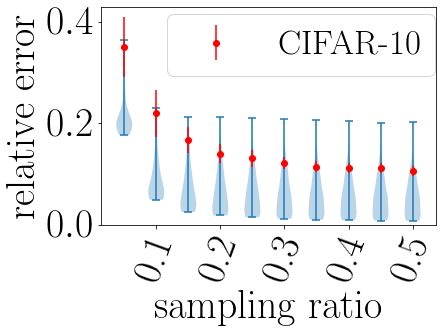

In [23]:
fontsize_axes = 40
fontsize_legend = 35

fig, ax = plt.subplots(nrows=1, ncols=1)

xtick_pos = [2, 4, 6, 8, 10]
ax.set_xticks(xtick_pos)
ax.set_xticklabels([0.1, 0.2, 0.3, 0.4, 0.5], fontsize=fontsize_axes, rotation=70)

ax.violinplot(relative_error_unif_by_dataset_mean.T, showextrema=True)
ax.errorbar(np.arange(len(observation_ratios))+1, relative_error_unif_by_dataset_mean[:, 0], 
            relative_error_unif_by_dataset_std[:, 0], fmt='o', color='red', label='CIFAR-10') # cifar10
plt.yticks(fontsize=fontsize_axes)
plt.ylim(bottom=0)
plt.legend(loc='upper', bbox_to_anchor=(1.05, 1.05), fontsize=fontsize_legend, ncol=1)
ax.set_xlabel('sampling ratio', fontsize=fontsize_axes)
ax.set_ylabel('relative error', fontsize=fontsize_axes)

Text(0, 0.5, 'convergence')

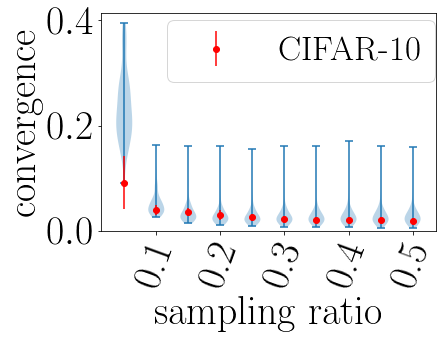

In [24]:
fontsize_axes = 40
fontsize_legend = 35

fig, ax = plt.subplots(nrows=1, ncols=1)

xtick_pos = [2, 4, 6, 8, 10]
ax.set_xticks(xtick_pos)
ax.set_xticks(xtick_pos)
ax.set_xticklabels([0.1, 0.2, 0.3, 0.4, 0.5], fontsize=fontsize_axes, rotation=70)

ax.violinplot(dist_unif_by_dataset_mean.T, showextrema=True)
ax.errorbar(np.arange(len(observation_ratios))+1, dist_unif_by_dataset_mean[:, 0], 
            dist_unif_by_dataset_std[:, 0], fmt='o', color='red', label='CIFAR-10') # cifar10
plt.yticks(fontsize=fontsize_axes)
plt.ylim(bottom=0)
plt.legend(loc='upper', bbox_to_anchor=(1.05, 1.05), fontsize=fontsize_legend, ncol=1)
ax.set_xlabel('sampling ratio', fontsize=fontsize_axes)
ax.set_ylabel('convergence', fontsize=fontsize_axes)

Text(0, 0.5, 'HyperDiff')

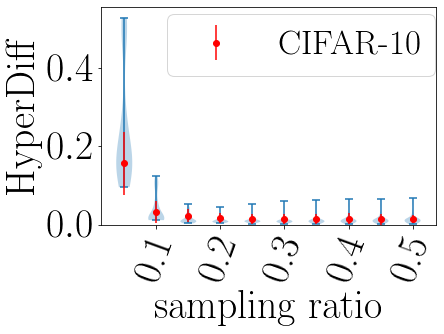

In [25]:
fontsize_axes = 40
fontsize_legend = 35

# Create a figure instance
fig, ax = plt.subplots(nrows=1, ncols=1)

# ax.set_xticks(observation_ratios)
# ax.set_xticks(np.arange(len(observation_ratios))+1)
# ax.set_xticklabels(observation_ratios)

xtick_pos = [2, 4, 6, 8, 10]
ax.set_xticks(xtick_pos)
ax.set_xticklabels([0.1, 0.2, 0.3, 0.4, 0.5], fontsize=fontsize_axes, rotation=70)


ax.violinplot(hypervolume_difference_unif_by_dataset_mean.T, showextrema=True)
ax.errorbar(np.arange(len(observation_ratios))+1, hypervolume_difference_unif_by_dataset_mean[:, 0], 
            hypervolume_difference_unif_by_dataset_std[:, 0], fmt='o', color='red', label='CIFAR-10') # cifar10
plt.yticks(fontsize=fontsize_axes)
plt.ylim(bottom=0)
plt.legend(loc='upper', bbox_to_anchor=(1.05, 1.05), fontsize=fontsize_legend, ncol=1)
ax.set_xlabel('sampling ratio', fontsize=fontsize_axes)
# ax.set_ylabel('hypervolume \n difference', fontsize=fontsize_axes)
ax.set_ylabel('HyperDiff', fontsize=fontsize_axes)

# nonuniform sampling

In [26]:
max_prob_all = np.linspace(0.1, 1, 10).round(decimals=1)

In [27]:
max_prob_all

array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])

In [28]:
inverse_memory_sorted = np.sort((1/memory_matrix_part).flatten())
inverse_memory_cdf = np.arange(len(inverse_memory_sorted)) / (len(inverse_memory_sorted) - 1)
sampling_prob_non_unif_original = inverse_memory_cdf[np.argsort(np.argsort((1/memory_matrix_part).flatten())).reshape(memory_matrix_part.shape)]

In [29]:
def run_nonuniform_sampling_scaling(idx_rep, idx_max_prob):
    max_prob = max_prob_all[idx_max_prob]
    seed = int((idx_rep+1)*(idx_max_prob+1))
    print("rep {}, max prob {} (random seed {})".format(idx_rep, max_prob, seed))
    sampling_prob_non_unif = sampling_prob_non_unif_original * max_prob
    error_matrix_part_obs_non_unif, M_non_unif = nonuniform_sampling(sampling_prob_non_unif, error_matrix_part, seed=seed)
    W_non_unif = 1/sampling_prob_non_unif
    error_matrix_part_pred_non_unif = weighted_softimpute(np.nan_to_num(error_matrix_part_obs_non_unif), M_non_unif, W_non_unif, 
                                       lmbda=.1, max_rank=5, min_value=0, max_value=1)

    memory_usage = np.sum(memory_matrix_part[M_non_unif.astype(bool)])
    sampling_ratio = np.sum(M_non_unif) / np.prod(M_non_unif.shape)
    
    dist_non_unif_all = []
    val_hypervolume_difference_all = []
    relative_error_all = []
    
    # loop over datasets
    for idx_dataset in range(error_matrix_part.shape[0]):
        relative_error_all.append(relative_error(error_matrix_part[idx_dataset], error_matrix_part_pred_non_unif[idx_dataset]))
        
        error_matrix_part_single_ds = error_matrix_part[idx_dataset]
        memory_matrix_part_single_ds = memory_matrix_part[idx_dataset]
        error_matrix_part_pred_non_unif_single_ds = error_matrix_part_pred_non_unif[idx_dataset]
        
        error_matrix_part_single_ds_flattened = error_matrix_part_single_ds.flatten()
        memory_matrix_part_single_ds_flattened = memory_matrix_part_single_ds.flatten()
        error_matrix_part_pred_non_unif_single_ds_flattened = error_matrix_part_pred_non_unif_single_ds.flatten()        
    
        # get true PF
        costs = np.hstack((memory_matrix_part_single_ds_flattened.reshape(-1, 1), 
                           error_matrix_part_single_ds_flattened.reshape(-1, 1)))
        is_efficient = is_pareto_efficient_dumb(costs)
        indices_true_frontier = np.where(is_efficient)[0]

        error_true_at_true_frontier = error_matrix_part_single_ds_flattened[indices_true_frontier]
        memory_true_at_true_frontier = memory_matrix_part_single_ds_flattened[indices_true_frontier]
        range_error_true = np.max(error_matrix_part_single_ds_flattened) - np.min(error_matrix_part_single_ds_flattened)

        # get predicted PF
        costs_error_pred = np.hstack((memory_matrix_part_single_ds_flattened.reshape(-1, 1), 
                                      error_matrix_part_pred_non_unif_single_ds_flattened.reshape(-1, 1)))
        is_efficient_pred = is_pareto_efficient_dumb(costs_error_pred)
        indices_pred_frontier = np.where(is_efficient_pred)[0]
        error_pred_at_true_frontier = error_matrix_part_pred_non_unif_single_ds_flattened[indices_true_frontier]
        error_pred_at_pred_frontier = error_matrix_part_pred_non_unif_single_ds_flattened[indices_pred_frontier]
        memory_true_at_pred_frontier = memory_matrix_part_single_ds_flattened[indices_pred_frontier]
        
        max_error = 1
        max_memory = np.max(memory_matrix_flattened)

        dist_non_unif_single_ds = get_convergence_metric(error_true_at_true_frontier, memory_true_at_true_frontier, 
                                          error_pred_at_pred_frontier, memory_true_at_pred_frontier,
                                            max_error, max_error, max_memory)  # do not standardize errors for now

        val_hypervolume_difference_single_ds = hypervolume_difference(error_true_at_true_frontier, memory_true_at_true_frontier,
                                                           error_pred_at_pred_frontier, memory_true_at_pred_frontier,
                                                           max_error, max_error, max_memory, max_error, max_memory)
    
        dist_non_unif_all.append(dist_non_unif_single_ds)
        val_hypervolume_difference_all.append(val_hypervolume_difference_single_ds)
        
    dist_non_unif_all = np.array(dist_non_unif_all)    
    val_hypervolume_difference_all = np.array(val_hypervolume_difference_all)
    relative_error_all = np.array(relative_error_all)
    
    return relative_error_all, dist_non_unif_all, val_hypervolume_difference_all, sampling_ratio, memory_usage

In [30]:
n_reps = 100
combs = list(itertools.product(range(n_reps), range(len(max_prob_all))))

p1 = mp.Pool(100)
results = [p1.apply_async(run_nonuniform_sampling_scaling, args=[idx_rep, idx_max_prob]) for idx_rep, idx_max_prob in combs]
p1.close()
p1.join()

rep 0, max prob 0.2 (random seed 2)rep 0, max prob 0.1 (random seed 1)rep 0, max prob 0.4 (random seed 4)rep 0, max prob 0.3 (random seed 3)rep 0, max prob 0.5 (random seed 5)rep 0, max prob 0.7 (random seed 7)rep 1, max prob 0.2 (random seed 4)rep 0, max prob 0.9 (random seed 9)rep 0, max prob 0.8 (random seed 8)rep 1, max prob 0.1 (random seed 2)rep 0, max prob 0.6 (random seed 6)rep 0, max prob 1.0 (random seed 10)rep 1, max prob 0.4 (random seed 8)rep 1, max prob 0.5 (random seed 10)rep 1, max prob 0.8 (random seed 16)rep 1, max prob 0.6 (random seed 12)rep 2, max prob 0.5 (random seed 15)rep 1, max prob 0.7 (random seed 14)rep 2, max prob 0.2 (random seed 6)rep 1, max prob 0.9 (random seed 18)rep 1, max prob 0.3 (random seed 6)rep 2, max prob 0.1 (random seed 3)rep 1, max prob 1.0 (random seed 20)rep 2, max prob 0.6 (random seed 18)rep 2, max prob 0.3 (random seed 9)rep 2, max prob 0.4 (random seed 12)rep 2, max prob 1.0 (random seed 30)rep 2, max prob 0.7 (random seed 21)rep 2, m

rep 21, max prob 0.6 (random seed 132)rep 21, max prob 0.7 (random seed 154)rep 21, max prob 0.8 (random seed 176)


rep 21, max prob 0.9 (random seed 198)
rep 21, max prob 1.0 (random seed 220)
rep 22, max prob 0.1 (random seed 23)
rep 22, max prob 0.2 (random seed 46)rep 22, max prob 0.3 (random seed 69)

rep 22, max prob 0.5 (random seed 115)rep 22, max prob 0.4 (random seed 92)

rep 22, max prob 0.6 (random seed 138)
rep 22, max prob 0.7 (random seed 161)
rep 22, max prob 0.8 (random seed 184)
rep 22, max prob 0.9 (random seed 207)
rep 22, max prob 1.0 (random seed 230)
rep 23, max prob 0.1 (random seed 24)
rep 23, max prob 0.2 (random seed 48)
rep 23, max prob 0.3 (random seed 72)
rep 23, max prob 0.4 (random seed 96)
rep 23, max prob 0.5 (random seed 120)
rep 23, max prob 0.6 (random seed 144)
rep 23, max prob 0.7 (random seed 168)
rep 23, max prob 0.8 (random seed 192)
rep 23, max prob 0.9 (random seed 216)
rep 23, max prob 1.0 (random seed 240)
rep 24, max prob 0.1 (random seed

rep 42, max prob 0.7 (random seed 301)
rep 42, max prob 0.8 (random seed 344)
rep 42, max prob 0.9 (random seed 387)
rep 42, max prob 1.0 (random seed 430)
rep 43, max prob 0.1 (random seed 44)
rep 43, max prob 0.2 (random seed 88)
rep 43, max prob 0.3 (random seed 132)
rep 43, max prob 0.4 (random seed 176)
rep 43, max prob 0.5 (random seed 220)rep 43, max prob 0.6 (random seed 264)

rep 43, max prob 0.7 (random seed 308)
rep 43, max prob 0.8 (random seed 352)
rep 43, max prob 0.9 (random seed 396)
rep 43, max prob 1.0 (random seed 440)
rep 44, max prob 0.1 (random seed 45)
rep 44, max prob 0.2 (random seed 90)
rep 44, max prob 0.3 (random seed 135)
rep 44, max prob 0.4 (random seed 180)
rep 44, max prob 0.5 (random seed 225)
rep 44, max prob 0.6 (random seed 270)
rep 44, max prob 0.7 (random seed 315)
rep 44, max prob 0.8 (random seed 360)
rep 44, max prob 0.9 (random seed 405)
rep 44, max prob 1.0 (random seed 450)
rep 45, max prob 0.1 (random seed 46)
rep 45, max prob 0.2 (random s

rep 63, max prob 0.7 (random seed 448)
rep 63, max prob 0.8 (random seed 512)
rep 63, max prob 0.9 (random seed 576)
rep 63, max prob 1.0 (random seed 640)
rep 64, max prob 0.1 (random seed 65)
rep 64, max prob 0.2 (random seed 130)
rep 64, max prob 0.3 (random seed 195)
rep 64, max prob 0.4 (random seed 260)
rep 64, max prob 0.5 (random seed 325)
rep 64, max prob 0.6 (random seed 390)
rep 64, max prob 0.7 (random seed 455)
rep 64, max prob 0.8 (random seed 520)
rep 64, max prob 0.9 (random seed 585)
rep 64, max prob 1.0 (random seed 650)
rep 65, max prob 0.1 (random seed 66)
rep 65, max prob 0.2 (random seed 132)
rep 65, max prob 0.3 (random seed 198)
rep 65, max prob 0.4 (random seed 264)
rep 65, max prob 0.5 (random seed 330)
rep 65, max prob 0.6 (random seed 396)
rep 65, max prob 0.7 (random seed 462)
rep 65, max prob 0.8 (random seed 528)
rep 65, max prob 0.9 (random seed 594)
rep 65, max prob 1.0 (random seed 660)
rep 66, max prob 0.1 (random seed 67)
rep 66, max prob 0.2 (random

rep 84, max prob 0.7 (random seed 595)
rep 84, max prob 0.8 (random seed 680)
rep 84, max prob 0.9 (random seed 765)
rep 84, max prob 1.0 (random seed 850)
rep 85, max prob 0.1 (random seed 86)
rep 85, max prob 0.2 (random seed 172)
rep 85, max prob 0.3 (random seed 258)
rep 85, max prob 0.4 (random seed 344)
rep 85, max prob 0.5 (random seed 430)
rep 85, max prob 0.6 (random seed 516)
rep 85, max prob 0.7 (random seed 602)
rep 85, max prob 0.8 (random seed 688)
rep 85, max prob 0.9 (random seed 774)
rep 85, max prob 1.0 (random seed 860)
rep 86, max prob 0.2 (random seed 174)rep 86, max prob 0.3 (random seed 261)

rep 86, max prob 0.4 (random seed 348)
rep 86, max prob 0.1 (random seed 87)rep 86, max prob 0.5 (random seed 435)

rep 86, max prob 0.6 (random seed 522)
rep 86, max prob 0.7 (random seed 609)
rep 86, max prob 0.8 (random seed 696)
rep 86, max prob 0.9 (random seed 783)
rep 86, max prob 1.0 (random seed 870)
rep 87, max prob 0.1 (random seed 88)
rep 87, max prob 0.2 (random

In [31]:
n_datasets = error_matrix_part.shape[0]

relative_error_non_unif_all = np.full((n_reps, len(max_prob_all), n_datasets), np.nan)
dist_non_unif_all = np.full((n_reps, len(max_prob_all), n_datasets), np.nan)
hypervolume_difference_non_unif_all = np.full((n_reps, len(max_prob_all), n_datasets), np.nan)
memory_usage_non_unif_all = np.full((n_reps, len(max_prob_all)), np.nan)
sampling_ratio_non_unif_all = np.full((n_reps, len(max_prob_all)), np.nan)

for i, (idx_rep, idx_prob) in enumerate(combs):
    relative_error_non_unif_all[idx_rep, idx_prob] = results[i].get()[0]
    dist_non_unif_all[idx_rep, idx_prob] = results[i].get()[1]
    hypervolume_difference_non_unif_all[idx_rep, idx_prob] = results[i].get()[2]
    sampling_ratio_non_unif_all[idx_rep, idx_prob] = results[i].get()[3]
    memory_usage_non_unif_all[idx_rep, idx_prob] = results[i].get()[4]

sampling_ratio_non_unif_mean = np.average(sampling_ratio_non_unif_all, axis=0)
memory_usage_non_unif_mean = np.average(memory_usage_non_unif_all, axis=0)

relative_error_non_unif_by_dataset_mean = np.average(relative_error_non_unif_all, axis=0)
relative_error_non_unif_by_dataset_median = np.median(relative_error_non_unif_all, axis=0)
relative_error_non_unif_by_dataset_std = np.std(relative_error_non_unif_all, axis=0)

dist_non_unif_by_dataset_mean = np.average(dist_non_unif_all, axis=0)
dist_non_unif_by_dataset_median = np.median(dist_non_unif_all, axis=0)
dist_non_unif_by_dataset_std = np.std(dist_non_unif_all, axis=0)

hypervolume_difference_non_unif_by_dataset_mean = np.average(hypervolume_difference_non_unif_all, axis=0)
hypervolume_difference_non_unif_by_dataset_median = np.median(hypervolume_difference_non_unif_all, axis=0)
hypervolume_difference_non_unif_by_dataset_std = np.std(hypervolume_difference_non_unif_all, axis=0)

In [32]:
memory_usage_non_unif_mean_ratio = memory_usage_non_unif_mean / np.sum(memory_matrix_part)

Text(0, 0.5, 'relative error')

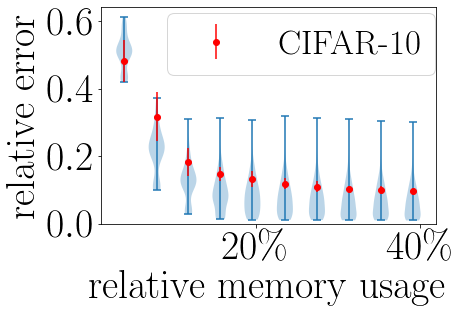

In [33]:
fontsize_axes = 40
fontsize_legend = 35

# Create a figure instance
fig, ax = plt.subplots(nrows=1, ncols=1)

positions = memory_usage_non_unif_mean_ratio / memory_usage_non_unif_mean_ratio[0]

xtick_percentages = [0, 20, 40]
xtick_labels = ['{:.0f}\%'.format(item) for item in xtick_percentages]
xtick_pos = [item / (100*memory_usage_non_unif_mean_ratio[0]) for item in xtick_percentages]
ax.set_xticks(xtick_pos)
ax.set_xticklabels(xtick_labels, fontsize=fontsize_axes)

ax.violinplot(relative_error_non_unif_by_dataset_mean.T, positions=positions, showextrema=True)
ax.errorbar(positions, relative_error_non_unif_by_dataset_mean[:, 0], 
            relative_error_non_unif_by_dataset_std[:, 0], fmt='o', color='red', label='CIFAR-10') # cifar10
plt.yticks(fontsize=fontsize_axes)
plt.ylim(bottom=0)
plt.legend(loc='upper', bbox_to_anchor=(1.05, 1.05), fontsize=fontsize_legend, ncol=1)
ax.set_xlabel('relative memory usage', fontsize=fontsize_axes)
ax.set_ylabel('relative error', fontsize=fontsize_axes)

Text(0, 0.5, 'convergence')

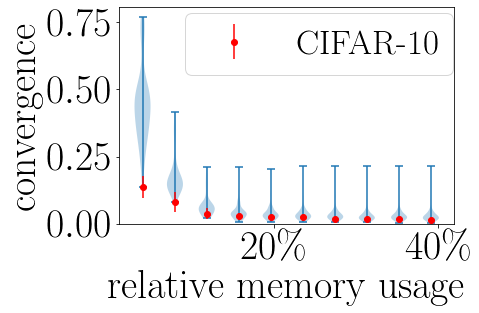

In [34]:
fontsize_axes = 40
fontsize_legend = 35

# Create a figure instance
fig, ax = plt.subplots(nrows=1, ncols=1)

positions = memory_usage_non_unif_mean_ratio / memory_usage_non_unif_mean_ratio[0]

xtick_percentages = [0, 20, 40]
xtick_labels = ['{:.0f}\%'.format(item) for item in xtick_percentages]
xtick_pos = [item / (100*memory_usage_non_unif_mean_ratio[0]) for item in xtick_percentages]
ax.set_xticks(xtick_pos)
ax.set_xticklabels(xtick_labels, fontsize=fontsize_axes)

ax.violinplot(dist_non_unif_by_dataset_mean.T, positions=positions, showextrema=True)
    
ax.errorbar(positions, dist_non_unif_by_dataset_mean[:, 0], 
            dist_non_unif_by_dataset_std[:, 0], fmt='o', color='red', label='CIFAR-10') # cifar10
plt.yticks(fontsize=fontsize_axes)
plt.ylim(bottom=0)
plt.legend(loc='upper', bbox_to_anchor=(1.05, 1.05), fontsize=fontsize_legend, ncol=1)
ax.set_xlabel('relative memory usage', fontsize=fontsize_axes)
ax.set_ylabel('convergence', fontsize=fontsize_axes)

Text(0, 0.5, 'HyperDiff')

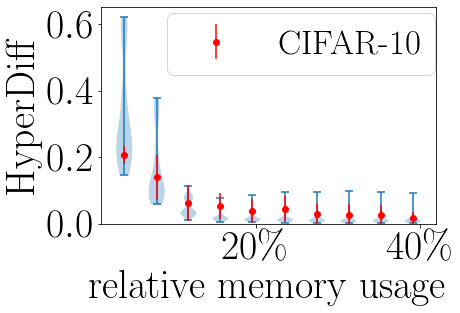

In [35]:
fontsize_axes = 40
fontsize_legend = 35

# Create a figure instance
fig, ax = plt.subplots(nrows=1, ncols=1)

positions = memory_usage_non_unif_mean_ratio / memory_usage_non_unif_mean_ratio[0]

xtick_percentages = [0, 20, 40]
xtick_labels = ['{:.0f}\%'.format(item) for item in xtick_percentages]
xtick_pos = [item / (100*memory_usage_non_unif_mean_ratio[0]) for item in xtick_percentages]
ax.set_xticks(xtick_pos)
ax.set_xticklabels(xtick_labels, fontsize=fontsize_axes)

ax.violinplot(hypervolume_difference_non_unif_by_dataset_mean.T, positions=positions, showextrema=True)
ax.errorbar(positions, hypervolume_difference_non_unif_by_dataset_mean[:, 0], 
            hypervolume_difference_non_unif_by_dataset_std[:, 0], fmt='o', color='red', label='CIFAR-10') # cifar10
plt.yticks(fontsize=fontsize_axes)
plt.ylim(bottom=0)
plt.legend(loc='upper', bbox_to_anchor=(1.05, 1.05), fontsize=fontsize_legend, ncol=1)
ax.set_xlabel('relative memory usage', fontsize=fontsize_axes)
ax.set_ylabel('HyperDiff', fontsize=fontsize_axes)